In [1]:
import numpy as np
import sys
sys.path.append("../../src")
import hipopy
from ECALDataReader import ECALDataReader
import particle
import ROOT
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
hipobase = "clasdispr.00.e10.600.emn0.75tmn.09.xs68.34nb.dis."
def generate_padded_numbers(a, b):
    return [str(i).zfill(4) for i in range(a, b+1)]

# Example usage
hiponums = generate_padded_numbers(0, 100)
print(hiponums)
#hiponums = ["0000"]
hipoproj = "../../projects/converge.10.14.2024.13.20/"

def get_hipos(version=None):
    assert(version in ["old","new"])
    hipofiles = []
    for hiponum in hiponums:
        if version=="old":
            hipofiles.append(f"{hipoproj}/cooked/{hipobase}{hiponum}.hipo")
        else:
            hipofiles.append(f"{hipoproj}/predict/{hipobase}{hiponum}_ML.hipo")
    return hipofiles

oldhipos = get_hipos("old")
newhipos = get_hipos("new")

def get_particle_mass(pid):
    try:
        # Create a Particle instance from the given PID
        particle = Particle.from_pdgid(pid)
        # Return the mass of the particle
        return particle.mass
    except Exception:
        # Return 0 mass if the PID is not recognized
        return 0.0

import pandas as pd
import numpy as np
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

def get_particle_properties(particle_df):
    # Initialize dictionary for particle properties
    properties = {"electron": [],
                  "proton":   [],
                  "neutron":  [],
                  "piplus":   [],
                  "piminus":  [],
                  "photon":   []}
    
    for index, particle in particle_df.iterrows():
        px = particle.px
        py = particle.py
        pz = particle.pz
        try:
            beta = particle.beta
        except:
            beta = -1
        p = np.sqrt(px**2 + py**2 + pz**2)
        pid = particle.pid
        m = get_particle_mass(pid)
        E = np.sqrt(p**2 + m**2)  # Energy from p and m
        theta = np.arctan2(np.sqrt(px**2 + py**2), pz)  # Polar angle
        phi = np.arctan2(py, px)  # Azimuthal angle
        
        particle_data = {"p": p, "theta": theta, "phi": phi, "E": E, "beta": beta}
        
        if pid == 11:  # Electron
            properties["electron"].append(particle_data)
        elif pid == 2212:  # Proton
            properties["proton"].append(particle_data)
        elif pid == 2112:  # Neutron
            properties["neutron"].append(particle_data)
        elif pid == 211:  # Pi+
            properties["piplus"].append(particle_data)
        elif pid == -211:  # Pi-
            properties["piminus"].append(particle_data)
        elif pid == 22:  # Photon
            properties["photon"].append(particle_data)
    
    return properties

def get_particles(hipofile=""):
    reader = ECALDataReader(hipofile)
    
    # Initialize total vectors dictionaries
    total_rec_properties = {"electron": [],
                            "proton":   [],
                            "neutron":  [],
                            "piplus":   [],
                            "piminus":  [],
                            "photon":   []}
    
    total_mc_properties = {"electron": [],
                           "proton":   [],
                           "neutron":  [],
                           "piplus":   [],
                           "piminus":  [],
                           "photon":   []}
    
    for iev, event in tqdm(enumerate(reader.file)):
        rec_parts = reader.get_dict("REC::Particle")
        mc_parts  = reader.get_dict("MC::Particle")

        rec_properties = get_particle_properties(rec_parts)
        mc_properties  = get_particle_properties(mc_parts)

        # Accumulate REC properties
        for key in total_rec_properties:
            total_rec_properties[key].extend(rec_properties[key])
        
        # Accumulate MC properties
        for key in total_mc_properties:
            total_mc_properties[key].extend(mc_properties[key])

    return total_rec_properties, total_mc_properties

def process_single_file(hipofile):
    # Process a single HIPO file
    total_rec_properties, total_mc_properties = get_particles(hipofile)
    return total_rec_properties, total_mc_properties

def ana_parallel(hipofiles, max_workers=4):
    # Initialize grand total dictionaries for rec and mc properties
    grand_total_rec_properties = {"electron": [],
                                  "proton":   [],
                                  "neutron":  [],
                                  "piplus":   [],
                                  "piminus":  [],
                                  "photon":   []}
    
    grand_total_mc_properties = {"electron": [],
                                 "proton":   [],
                                 "neutron":  [],
                                 "piplus":   [],
                                 "piminus":  [],
                                 "photon":   []}

    # Use ProcessPoolExecutor to parallelize processing
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks to the pool
        results = list(tqdm(executor.map(process_single_file, hipofiles), total=len(hipofiles)))
    
    # Accumulate REC and MC properties from each result
    for total_rec_properties, total_mc_properties in results:
        for key in grand_total_rec_properties:
            grand_total_rec_properties[key].extend(total_rec_properties[key])
        for key in grand_total_mc_properties:
            grand_total_mc_properties[key].extend(total_mc_properties[key])
    
    # Return the grand totals
    return grand_total_rec_properties, grand_total_mc_properties

# Example usage:
old_rec_vecs, old_mc_vecs = ana_parallel(oldhipos, max_workers=32)
new_rec_vecs, new_mc_vecs = ana_parallel(newhipos, max_workers=32)

['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038', '0039', '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049', '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0057', '0058', '0059', '0060', '0061', '0062', '0063', '0064', '0065', '0066', '0067', '0068', '0069', '0070', '0071', '0072', '0073', '0074', '0075', '0076', '0077', '0078', '0079', '0080', '0081', '0082', '0083', '0084', '0085', '0086', '0087', '0088', '0089', '0090', '0091', '0092', '0093', '0094', '0095', '0096', '0097', '0098', '0099', '0100']


957it [00:45, 17.06it/s]]                              | 0/101 [00:00<?, ?it/s]
957it [00:45, 20.69it/s]]
985it [00:46, 19.95it/s]]                    | 1/101 [00:46<1:18:07, 46.87s/it]
984it [00:46, 18.20it/s]]
967it [00:47, 23.71it/s]]
998it [00:47, 17.01it/s]]
994it [00:47, 22.36it/s]]
1000it [00:47, 21.25it/s]
974it [00:47, 20.76it/s]]
981it [00:47, 19.27it/s]]
998it [00:47, 20.31it/s]]
992it [00:47, 23.39it/s]]
990it [00:47, 23.18it/s]
984it [00:47, 14.38it/s]]
980it [00:47, 25.41it/s]]
1000it [00:48, 20.82it/s]
995it [00:48, 26.04it/s]]
990it [00:48, 23.46it/s]]
972it [00:48, 15.98it/s]]
993it [00:48, 23.18it/s]]
992it [00:48, 23.88it/s]
21it [00:00, 22.21it/s]]]
991it [00:48, 22.51it/s]]
13it [00:00, 20.75it/s]s]
42it [00:01, 29.77it/s]]]
6it [00:00, 10.94it/s]/s]
1000it [00:48, 20.68it/s]
8it [00:00, 28.63it/s]/s]
1000it [00:48, 20.52it/s]
1000it [00:48, 20.51it/s]
2it [00:00, 16.63it/s]
28it [00:01, 30.02it/s]s]                      | 2/101 [00:49<34:03, 20.64s/it]
1000it [00:

In [4]:
def plot_particle_moments(particle_type, rec_properties, mc_properties, quantities=["p", "theta", "phi"], bins=50):
    # Prepare data for plotting
    rec_p = np.array([particle["p"] for particle in rec_properties[particle_type]])
    rec_theta = np.array([particle["theta"] for particle in rec_properties[particle_type]])
    rec_phi = np.array([particle["phi"] for particle in rec_properties[particle_type]])
    rec_beta = np.array([particle["beta"] for particle in rec_properties[particle_type]])

    mc_p = np.array([particle["p"] for particle in mc_properties[particle_type]])
    mc_theta = np.array([particle["theta"] for particle in mc_properties[particle_type]])
    mc_phi = np.array([particle["phi"] for particle in mc_properties[particle_type]])
    mc_beta = np.array([particle["beta"] for particle in mc_properties[particle_type]])

    # Determine common ranges for each quantity
    p_min, p_max = 0.001, 10
    theta_min, theta_max = 0.0001, 35/180*np.pi
    phi_min, phi_max = -np.pi, np.pi
    beta_min, beta_max = -1, 1

    # Initialize figure and dynamically adjust number of subplots based on quantities
    n_plots = len(quantities)
    fig, axs = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))
    if n_plots == 1:
        axs = [axs]  # Ensure axs is always a list even with 1 subplot

    # Index to avoid complications (apply only to p, theta, and beta)
    idx_rec = (rec_p > p_min) & (rec_p < p_max) & (rec_theta > theta_min) & (rec_theta < theta_max)
    idx_mc = (mc_p > p_min) & (mc_p < p_max) & (mc_theta > theta_min) & (mc_theta < theta_max)

    rec_p, rec_theta, rec_phi, rec_beta = rec_p[idx_rec], rec_theta[idx_rec], rec_phi[idx_rec], rec_beta[idx_rec]
    mc_p, mc_theta, mc_phi, mc_beta = mc_p[idx_mc], mc_theta[idx_mc], mc_phi[idx_mc], mc_beta[idx_mc]

    # Plot based on the specified quantities
    for i, quantity in enumerate(quantities):
        if quantity == "p":
            axs[i].hist(rec_p, bins=np.linspace(p_min, p_max, bins), color='red', alpha=0.5, label='REC', linewidth=2, histtype='stepfilled')
            axs[i].hist(mc_p, bins=np.linspace(p_min, p_max, bins), color='blue', alpha=0.5, label='MC', linewidth=2, histtype='stepfilled')
            axs[i].set_title(f'{particle_type.capitalize()} Momentum (p)')
            axs[i].set_xlabel('Momentum (GeV)')
            axs[i].set_ylabel('Counts')
            axs[i].legend()

        if quantity == "theta":
            axs[i].hist(rec_theta, bins=np.linspace(theta_min, theta_max, bins), color='red', alpha=0.5, label='REC', linewidth=2, histtype='stepfilled')
            axs[i].hist(mc_theta, bins=np.linspace(theta_min, theta_max, bins), color='blue', alpha=0.5, label='MC', linewidth=2, histtype='stepfilled')
            axs[i].set_title(f'{particle_type.capitalize()} Polar Angle (θ)')
            axs[i].set_xlabel('Theta (rad)')
            axs[i].set_ylabel('Counts')
            axs[i].legend()

        if quantity == "phi":
            axs[i].hist(rec_phi, bins=np.linspace(phi_min, phi_max, bins), color='red', alpha=0.5, label='REC', linewidth=2, histtype='stepfilled')
            axs[i].hist(mc_phi, bins=np.linspace(phi_min, phi_max, bins), color='blue', alpha=0.5, label='MC', linewidth=2, histtype='stepfilled')
            axs[i].set_title(f'{particle_type.capitalize()} Azimuthal Angle (φ)')
            axs[i].set_xlabel('Phi (rad)')
            axs[i].set_ylabel('Counts')
            axs[i].legend()

        if quantity == "beta":
            axs[i].hist(rec_beta, bins=np.linspace(beta_min, beta_max, bins), color='red', alpha=0.5, label='REC', linewidth=2, histtype='stepfilled')
            axs[i].hist(mc_beta, bins=np.linspace(beta_min, beta_max, bins), color='blue', alpha=0.5, label='MC', linewidth=2, histtype='stepfilled')
            axs[i].set_title(f'{particle_type.capitalize()} Beta (β)')
            axs[i].set_xlabel('Beta')
            axs[i].set_ylabel('Counts')
            axs[i].legend()

    # Adjust layout for better display
    plt.tight_layout()
    plt.show()

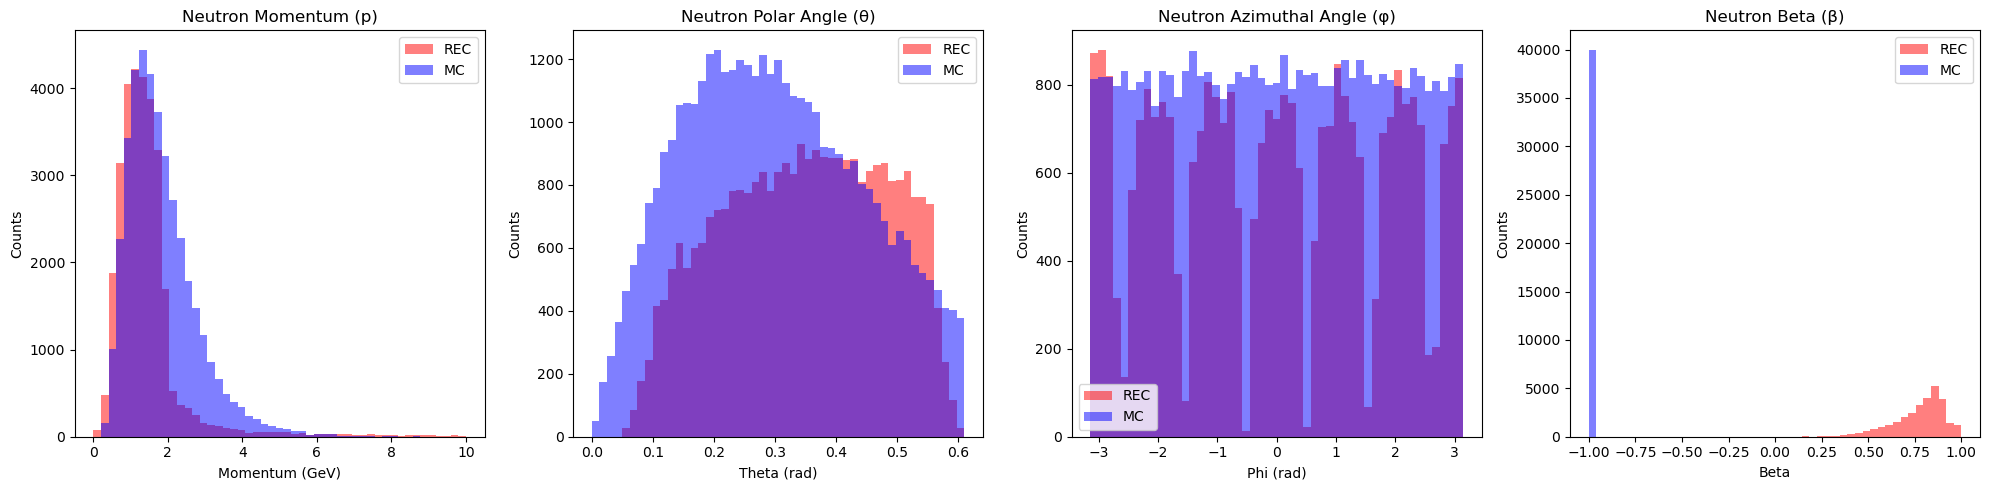

In [5]:
plot_particle_moments('neutron',new_rec_vecs, new_mc_vecs, quantities=["p", "theta", "phi","beta"])

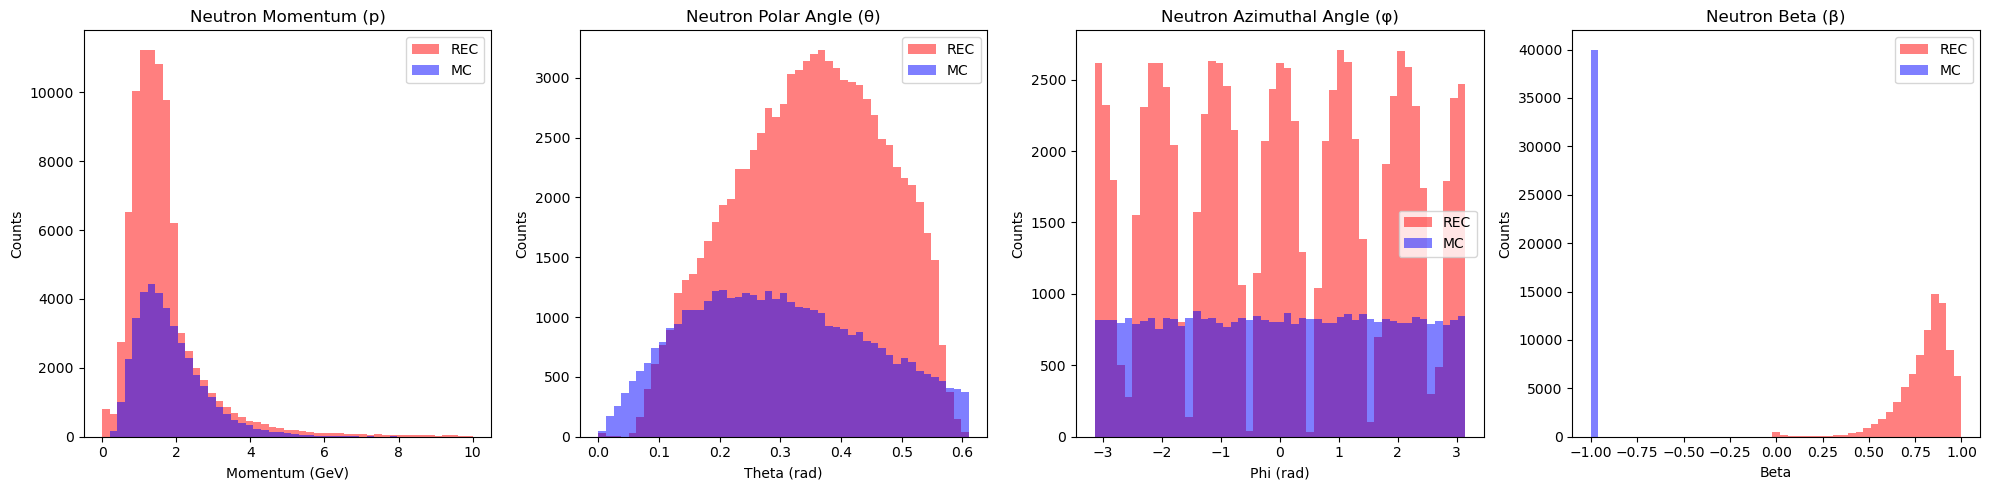

In [5]:
plot_particle_moments('neutron',old_rec_vecs, old_mc_vecs, quantities=["p", "theta", "phi","beta"])

In [18]:

def plot_particle_moments(particle_type, rec_properties, mc_properties, rec_old_properties, quantities=["p", "theta", "phi"], bins=50):
    # Prepare data for plotting
    rec_p = np.array([particle["p"] for particle in rec_properties[particle_type]])
    rec_theta = np.array([particle["theta"] for particle in rec_properties[particle_type]])
    rec_phi = np.array([particle["phi"] for particle in rec_properties[particle_type]])
    rec_beta = np.array([particle["beta"] for particle in rec_properties[particle_type]])

    rec_old_p = np.array([particle["p"] for particle in rec_old_properties[particle_type]])
    rec_old_theta = np.array([particle["theta"] for particle in rec_old_properties[particle_type]])
    rec_old_phi = np.array([particle["phi"] for particle in rec_old_properties[particle_type]])
    rec_old_beta = np.array([particle["beta"] for particle in rec_old_properties[particle_type]])

    mc_p = np.array([particle["p"] for particle in mc_properties[particle_type]])
    mc_theta = np.array([particle["theta"] for particle in mc_properties[particle_type]])
    mc_phi = np.array([particle["phi"] for particle in mc_properties[particle_type]])
    mc_beta = np.array([particle["beta"] for particle in mc_properties[particle_type]])

    # Determine common ranges for each quantity
    p_min, p_max = 0.001, 10
    theta_min, theta_max = 5/180*np.pi, 35/180*np.pi
    phi_min, phi_max = -np.pi, np.pi
    beta_min, beta_max = -1, 1

    # Initialize figure and dynamically adjust number of subplots based on quantities
    n_plots = len(quantities)
    fig, axs = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))
    if n_plots == 1:
        axs = [axs]  # Ensure axs is always a list even with 1 subplot

    # Index to avoid complications (apply only to p, theta, and beta)
    idx_rec = (rec_p > p_min) & (rec_p < p_max) & (rec_theta > theta_min) & (rec_theta < theta_max)
    idx_rec_old = (rec_old_p > p_min) & (rec_old_p < p_max) & (rec_old_theta > theta_min) & (rec_old_theta < theta_max)
    idx_mc = (mc_p > p_min) & (mc_p < p_max) & (mc_theta > theta_min) & (mc_theta < theta_max)

    rec_p, rec_theta, rec_phi, rec_beta = rec_p[idx_rec], rec_theta[idx_rec], rec_phi[idx_rec], rec_beta[idx_rec]
    rec_old_p, rec_old_theta, rec_old_phi, rec_old_beta = rec_old_p[idx_rec_old], rec_old_theta[idx_rec_old], rec_old_phi[idx_rec_old], rec_old_beta[idx_rec_old]
    mc_p, mc_theta, mc_phi, mc_beta = mc_p[idx_mc], mc_theta[idx_mc], mc_phi[idx_mc], mc_beta[idx_mc]

    # Plot based on the specified quantities
    for i, quantity in enumerate(quantities):
        if quantity == "p":
            axs[i].hist(rec_p, bins=np.linspace(p_min, p_max, bins), color='blue', label='Object Condensation', linewidth=2, histtype='step')
            axs[i].hist(rec_old_p, bins=np.linspace(p_min, p_max, bins), color='red', label='Coatjava', linewidth=2, histtype='step')
            axs[i].hist(mc_p, bins=np.linspace(p_min, p_max, bins), color='black', label='Monte Carlo', linewidth=2, histtype='step')
            axs[i].set_title(f'{particle_type.capitalize()} Momentum (p)')
            axs[i].set_xlabel('Momentum (GeV)')
            axs[i].set_ylabel('Counts')
            axs[i].legend(fontsize=15)

        if quantity == "theta":
            axs[i].hist(rec_theta, bins=np.linspace(theta_min, theta_max, bins), color='blue', label='Object Condensation', linewidth=2, histtype='step')
            axs[i].hist(rec_old_theta, bins=np.linspace(theta_min, theta_max, bins), color='red', label='Coatjava', linewidth=2, histtype='step')
            axs[i].hist(mc_theta, bins=np.linspace(theta_min, theta_max, bins), color='black', label='Monte Carlo', linewidth=2, histtype='step')
            axs[i].set_title(f'{particle_type.capitalize()} Polar Angle (θ)')
            axs[i].set_xlabel('Theta (rad)')
            axs[i].set_ylabel('Counts')
            axs[i].legend(fontsize=15)

        if quantity == "phi":
            axs[i].hist(rec_phi, bins=np.linspace(phi_min, phi_max, bins), color='blue', label='Object Condensation', linewidth=2, histtype='step')
            axs[i].hist(rec_old_phi, bins=np.linspace(phi_min, phi_max, bins), color='red', label='Coatjava', linewidth=2, histtype='step')
            axs[i].hist(mc_phi, bins=np.linspace(phi_min, phi_max, bins), color='black', label='Monte Carlo', linewidth=2, histtype='step')
            axs[i].set_title(f'{particle_type.capitalize()} Azimuthal Angle (φ)')
            axs[i].set_xlabel('Phi (rad)')
            axs[i].set_ylabel('Counts')
            axs[i].legend(fontsize=15)

        if quantity == "beta":
            axs[i].hist(rec_beta, bins=np.linspace(beta_min, beta_max, bins), color='blue', label='Object Condensation', linewidth=2, histtype='step')
            axs[i].hist(rec_old_beta, bins=np.linspace(beta_min, beta_max, bins), color='red', label='Coatjava', linewidth=2, histtype='step')
            axs[i].hist(mc_beta, bins=np.linspace(beta_min, beta_max, bins), color='black', label='Monte Carlo', linewidth=2, histtype='step')
            axs[i].set_title(f'{particle_type.capitalize()} Beta (β)')
            axs[i].set_xlabel('Beta')
            axs[i].set_ylabel('Counts')
            axs[i].legend(fontsize=15)

    # Adjust layout for better display
    plt.tight_layout()
    plt.show()

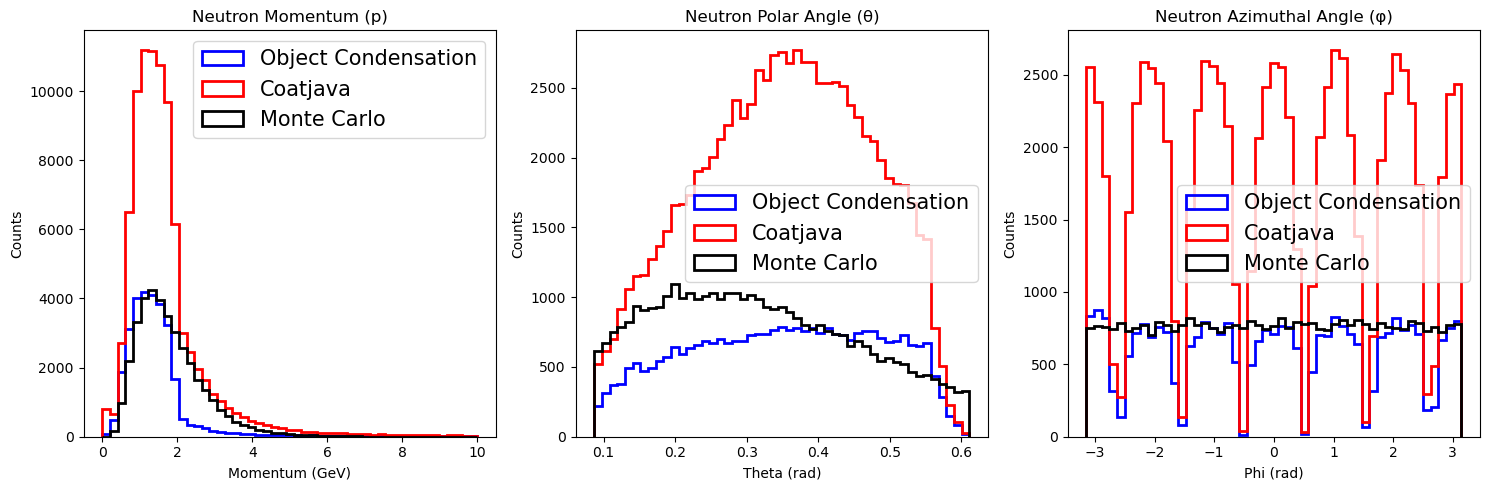

In [20]:
plot_particle_moments('neutron',new_rec_vecs, old_mc_vecs, old_rec_vecs, quantities=["p", "theta", "phi"])

In [58]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

def find_particle_matches(mc_parts, rec_parts, pid, deltaTheta=4, deltaPhi=8):
    # Initialize an empty list to store matched particles
    matched_particles = []
    
    # Iterate over the MC particles
    for mc_index, mc_particle in mc_parts.iterrows():
        if mc_particle['pid'] != pid:
            continue
        
        # MC particle information
        mc_px = mc_particle.px
        mc_py = mc_particle.py
        mc_pz = mc_particle.pz
        mc_p = np.sqrt(mc_px**2 + mc_py**2 + mc_pz**2)
        mc_theta = np.arctan2(np.sqrt(mc_px**2 + mc_py**2), mc_pz) * 180 / np.pi  # Theta in degrees
        mc_phi = np.arctan2(mc_py, mc_px)
        
        # Apply cuts on MC particle
        if mc_p < 0.0001 or mc_theta < 5 or mc_theta > 35:
            continue

        # Now look for matching reconstructed particles with the same PID
        for rec_index, rec_particle in rec_parts.iterrows():
            if rec_particle['pid'] != pid:
                continue

            # Reconstructed particle information
            rec_px = rec_particle.px
            rec_py = rec_particle.py
            rec_pz = rec_particle.pz
            rec_p = np.sqrt(rec_px**2 + rec_py**2 + rec_pz**2)
            rec_theta = np.arctan2(np.sqrt(rec_px**2 + rec_py**2), rec_pz) * 180 / np.pi  # Theta in degrees
            rec_phi = np.arctan2(rec_py, rec_px)

            # Apply cuts on the reconstructed particle
            if rec_p < 0.0001 or rec_theta < 5 or rec_theta > 35:
                continue
            dphi = np.abs(mc_phi - rec_phi)
            if dphi > 180:
                dphi = 360 - dphi
            dtheta = abs(mc_theta - rec_theta)
            if dtheta <= deltaTheta and dphi <= deltaPhi:
                # Append match to the list
                matched_particles.append({
                    'mc_P': mc_p, 'mc_Px': mc_px, 'mc_Py': mc_py, 'mc_Pz': mc_pz, 'mc_Theta': mc_theta, 'mc_Phi': mc_phi,
                    'rec_P': rec_p, 'rec_Px': rec_px, 'rec_Py': rec_py, 'rec_Pz': rec_pz, 'rec_Theta': rec_theta, 'rec_Phi': rec_phi
                })
            else:
                continue

    # Return the matches as a DataFrame
    return pd.DataFrame(matched_particles)

def get_particles(hipofile, pid):
    if "78" in hipofile:
        return 
    reader = ECALDataReader(hipofile)
    matched_particles = []
    
    for iev, event in enumerate(reader.file):
        rec_parts = reader.get_dict("REC::Particle")
        mc_parts  = reader.get_dict("MC::Particle")
        
        # Find matches for the current event and accumulate results
        matched_df = find_particle_matches(mc_parts, rec_parts, pid)
        matched_particles.append(matched_df)
    
    # Concatenate all matches for the current HIPO file
    return pd.concat(matched_particles, ignore_index=True)

def ana_single_file(hipofile, pid):
    # Process a single HIPO file
    return get_particles(hipofile, pid)

def ana_parallel(hipofiles, pid, max_workers=4):
    # Initialize an empty DataFrame to accumulate all the matched particle data
    all_matched_df = pd.DataFrame()
    
    # Use ProcessPoolExecutor to parallelize processing
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks to the pool
        results = list(tqdm(executor.map(ana_single_file, hipofiles, [pid] * len(hipofiles)), total=len(hipofiles)))

    # Concatenate all results into a single DataFrame
    all_matched_df = pd.concat(results, ignore_index=True)
    
    # Return the full DataFrame with all the matches
    return all_matched_df

# Example usage:
pid = 22
df_new_matches = ana_parallel(newhipos, pid, max_workers=8)
df_old_matches = ana_parallel(oldhipos, pid, max_workers=8)


100%|████████████████████████████████████████| 101/101 [04:23<00:00,  2.60s/it]


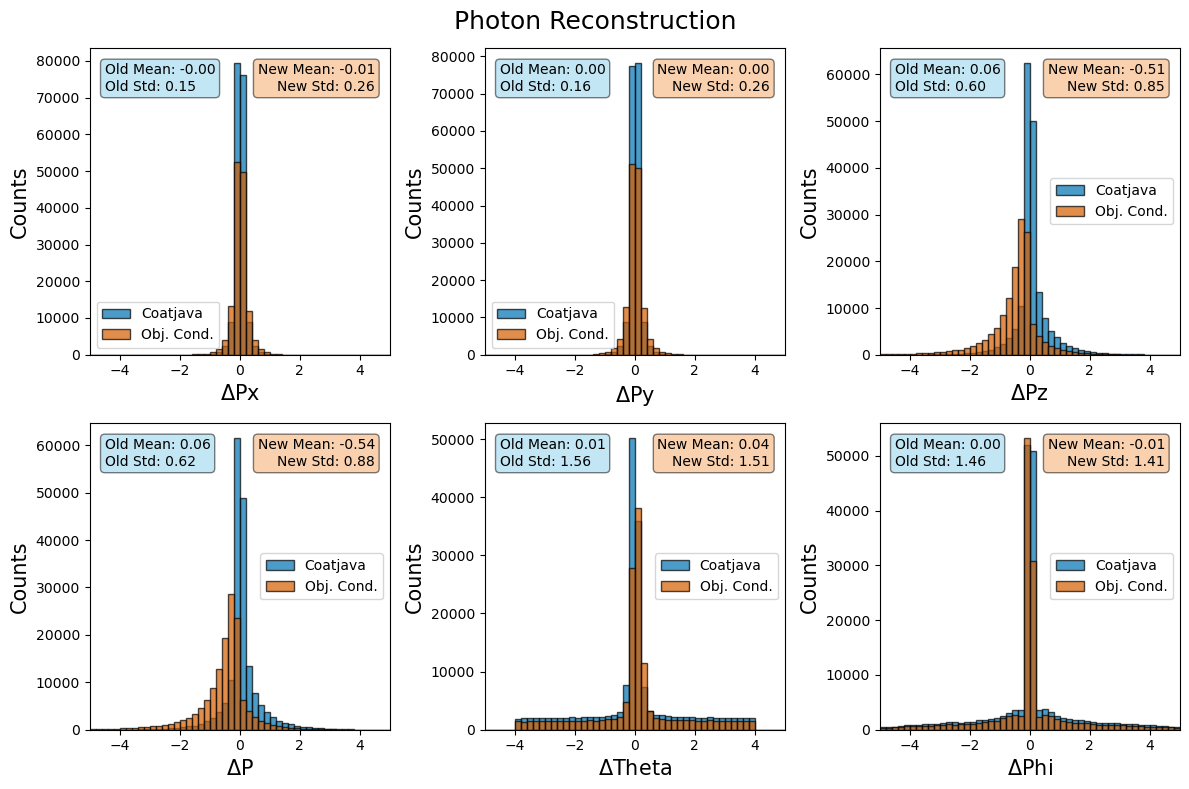

In [59]:
def plot_deltas_histograms(df_old, df_new, pid):
    # Calculate the deltas between MC and Reconstructed particles for both DataFrames
    for df in [df_old, df_new]:
        df['deltaPx'] = df['mc_Px'] - df['rec_Px']
        df['deltaPy'] = df['mc_Py'] - df['rec_Py']
        df['deltaPz'] = df['mc_Pz'] - df['rec_Pz']
        df['deltaP'] = df['mc_P'] - df['rec_P']
        df['deltaTheta'] = df['mc_Theta'] - df['rec_Theta']
        df['deltaPhi'] = df['mc_Phi'] - df['rec_Phi']
    
    # Define the delta columns you want to plot
    delta_columns = ['deltaPx', 'deltaPy', 'deltaPz', 'deltaP', 'deltaTheta', 'deltaPhi']
    
    # Create histograms for each delta
    plt.figure(figsize=(12, 8))

    xmin = -5
    xmax = 5

    # Define colors using a color-blind friendly palette
    color_old = '#0072B2'  # Blue for coatjava
    color_new = '#D55E00'  # Orange for object condensation

    for i, delta in enumerate(delta_columns, 1):
        plt.subplot(2, 3, i)  # Create a 2x3 grid of subplots
        
        # Filter data within the specified range
        data_old = df_old[delta]
        data_old = data_old[(data_old > xmin) & (data_old < xmax)]
        
        data_new = df_new[delta]
        data_new = data_new[(data_new > xmin) & (data_new < xmax)]
        
        # Calculate mean and standard deviation for old and new datasets
        mean_old = data_old.mean()
        std_old = data_old.std()
        
        mean_new = data_new.mean()
        std_new = data_new.std()
        
        # Plot the histograms for both datasets
        plt.hist(data_old, bins=50, range=(xmin, xmax), color=color_old, alpha=0.7, label='Coatjava', edgecolor='black')
        plt.hist(data_new, bins=50, range=(xmin, xmax), color=color_new, alpha=0.7, label='Obj. Cond.', edgecolor='black')
        
        # Set labels and limits
        plt.xlabel(delta.replace('delta','$\Delta$'), fontsize=15)
        plt.xlim(xmin, xmax)
        plt.ylabel('Counts', fontsize=15)

        # Add text for mean and std for both datasets
        plt.text(0.05, 0.95, f"Old Mean: {mean_old:.2f}\nOld Std: {std_old:.2f}", 
                 transform=plt.gca().transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle="round", facecolor="skyblue", alpha=0.5))

        plt.text(0.95, 0.95, f"New Mean: {mean_new:.2f}\nNew Std: {std_new:.2f}", 
                 transform=plt.gca().transAxes, fontsize=10,
                 verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="round", facecolor="sandybrown", alpha=0.5))
        
        # Add legend
        plt.legend()

    if pid==22:
        plt.suptitle("Photon Reconstruction",fontsize=18)
    elif pid==2112:
        plt.suptitle("Neutron Reconstruction",fontsize=18)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_deltas_histograms(df_old_matches, df_new_matches, pid=pid)

In [55]:
newhipos[0]

'../../projects/converge.10.14.2024.13.20//predict/clasdispr.00.e10.600.emn0.75tmn.09.xs68.34nb.dis.0000_ML.hipo'